# ch04.08 Transformer

* 날짜: 2022-09-06
* 이름: 고민수

## 학습내용
  - Transformer을 이해하고 구현한다.
  - Vision Transformer을 이해하고 구현한다.

## 참고 사이트

   - 논문 [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)


In [1]:
from lib_tf import *

Hangul OK in your window!


## 모듈 제작
---

### **| Multi Head Attention**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-09.PNG?raw=true?raw=true?raw=true
 width=350>
</p>

* set params

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-01.PNG?raw=true?raw=true
 width=850>
</p>


In [9]:
h = 8
d_k = 64
d_v = 64
d_model = 64 * h # 512 #embedding dims

# input * shape
# 시계열 : ( time range(window_size), channel )
# 텍스트 : ( max length, vocab size )
# 텍스트 임베딩 : ( max length, embedding dims )
T = 200
S = 100

# -> (V, K, Q)
Q = (T, d_model)
K = (S, d_model)
V = (S, d_model)

print(Q)
print(K)
print(V)

(200, 512)
(100, 512)
(100, 512)


In [11]:
def matmul(shape1, shape2):
    assert shape1[1] == shape2[0]
    return (shape1[0], shape2[1])
A = (100,300)
B = (300,200)
matmul(A,B)

(100, 200)

* Step1. Linear each  $Q, K, V(W^Q, W^K, W^V)$

<br>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-05.PNG?raw=true?raw=true?raw=true
 width=250>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-02-1.PNG?raw=true?raw=true
 width=850>
</p>



In [12]:
# set weights
W_Q = (d_model, d_k)
W_K = (d_model, d_k)
W_V = (d_model, d_v)
# calculate shape
VW = matmul(V, W_V)
KW = matmul(K, W_K)
QW = matmul(Q, W_Q)

print(f'Q {Q} x W_Q  {W_Q} = {QW}')
print(f'K {K} x W_K  {W_K} = {KW}')
print(f'V {V} x W_V  {W_V} = {VW}')

Q (200, 512) x W_Q  (512, 64) = (200, 64)
K (100, 512) x W_K  (512, 64) = (100, 64)
V (100, 512) x W_V  (512, 64) = (100, 64)


* Step2. Attention


<p align='center'>
<img src=https://wikidocs.net/images/page/159310/mha_img_original.png?raw=true
 width=450>
</p>


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-03.PNG?raw=true?raw=true
 width=850>
</p>

In [13]:
KW_T = (KW[1], KW[0])
print(f"QW: {QW}, KW_T: {KW_T}, VW: {VW}")

Att = matmul( matmul(QW, KW_T), VW)
print(f'Attention(QW, KW, VW) : {Att}')

QW: (200, 64), KW_T: (64, 100), VW: (100, 64)
Attention(QW, KW, VW) : (200, 64)


* step3. concat & Linear $(W^O)$

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-10.PNG?raw=true?raw=true?raw=true
 width=300>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-04.PNG?raw=true?raw=true
 width=850>
</p>

In [16]:
print(f'- Attention(QW, KW, VW) = head {Att}')

concat_att = (Att[0], Att[1]*h)
print(f'- Concat(head_1, ...head_h) = {concat_att}')

W_O = ( (h*d_v), d_model)
final_out = matmul(concat_att, W_O)
print(f'- Concat {concat_att} x W_O {W_O} = final output {final_out}' )

- Attention(QW, KW, VW) = head (200, 64)
- Concat(head_1, ...head_h) = (200, 512)
- Concat (200, 512) x W_O (512, 512) = final output (200, 512)


In [ ]:
print('- 인풋: ',  V, K, Q)
print(f'- 최종 아웃풋: {final_out}')

#### Tensorflow.keras MultiHeadAttention Layer

* docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention

```
tf.keras.layers.MultiHeadAttention(
    num_heads,
    key_dim,
    value_dim=None,
)

# call args

query	Query Tensor of shape (B, T, dim).
value	Value Tensor of shape (B, S, dim).
key	Optional key Tensor of shape (B, S, dim). If not given, will use 
```

In [25]:
h = 8
d_k = 64
d_v = 64
d_model = 64 * h  # 512

T = 200
S = 100

Q = (T, d_model)
K = (S, d_model)
V = (S, d_model)
###

Q = tf.keras.layers.Input(shape=(T, d_model))
V = tf.keras.layers.Input(shape=(S, d_model))
K = tf.keras.layers.Input(shape=(S, d_model))

y = tf.keras.layers.MultiHeadAttention(
    num_heads=h,
    key_dim=d_k,
    value_dim=d_v,  # d_k = d_v일 때는 적지 않아도 된다.
)(Q, V, K)

In [26]:
print(f'- 인풋: V {V.shape} K {K.shape} Q {Q.shape}')
print(f'- 최종 아웃풋: {y.shape}')

- 인풋: V (None, 100, 512) K (None, 100, 512) Q (None, 200, 512)
- 최종 아웃풋: (None, 200, 512)


### **| Encoder Block**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-11.PNG?raw=true?raw=true
 width=250>
</p>

In [41]:
def encoder_block(Input_shape, h, d_k, d_ff, dropout=0.25, name=None):
    Inputs = tf.keras.layers.Input(shape=Input_shape)
    # Attention and Normalization
    # multi-head
    y = tf.keras.layers.MultiHeadAttention(num_heads=h,
                                           key_dim=d_k,
                                           dropout=dropout)(Inputs, Inputs)
    y = tf.keras.layers.Dropout(dropout)(y)
    # Add & Norm
    y = tf.keras.layers.LayerNormalization()(y)
    y_1 = tf.keras.layers.Add()([y, Inputs])
    # Feed Forward Part
    ## FF
    y = tf.keras.layers.Conv1D(filters=d_ff,
                               kernel_size=1,
                               activation="leaky_relu")(y_1)
    y = tf.keras.layers.Dropout(dropout)(y)
    y = tf.keras.layers.Conv1D(filters=Inputs.shape[-1],
                               kernel_size=1,
                               activation="leaky_relu")(y)
    ## Add & Norm
    y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(y)
    outputs = tf.keras.layers.Add()([y, y_1])
    return tf.keras.models.Model(Inputs, outputs, name=name)

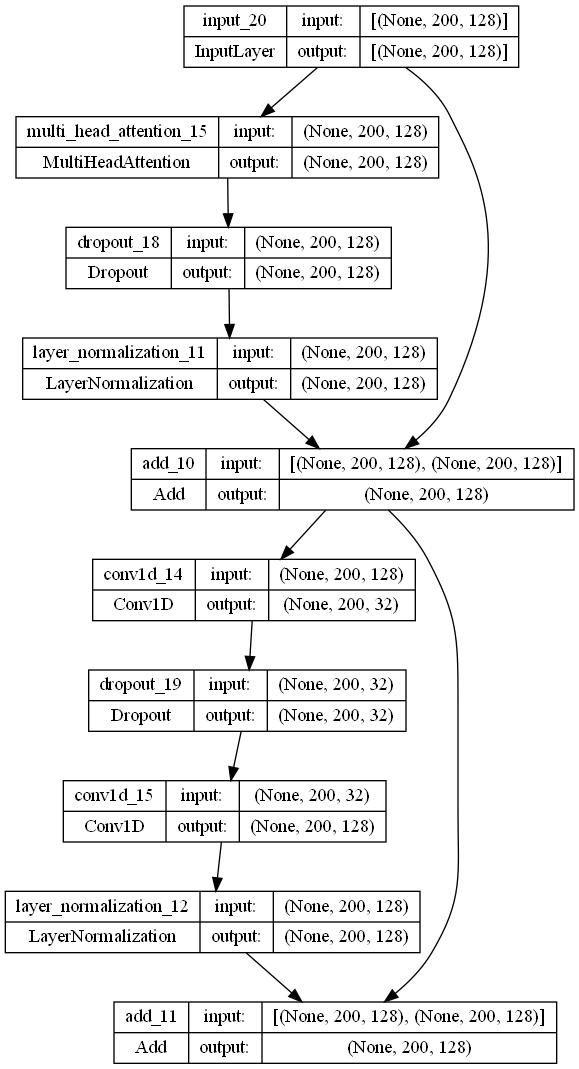

In [45]:
inputs_shape = (200, 128)
h = 8
d_k = 64
d_ff = 32

encoder= encoder_block(inputs_shape, h, d_k, d_ff)
tf.keras.utils.plot_model(encoder, show_shapes=True)

## 실습1. 시계열 데이터 분류
---

### **| 시계열 데이터셋**

In [46]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [47]:
import matplotlib.pyplot as plt

(3601, 500, 1) (3601,)


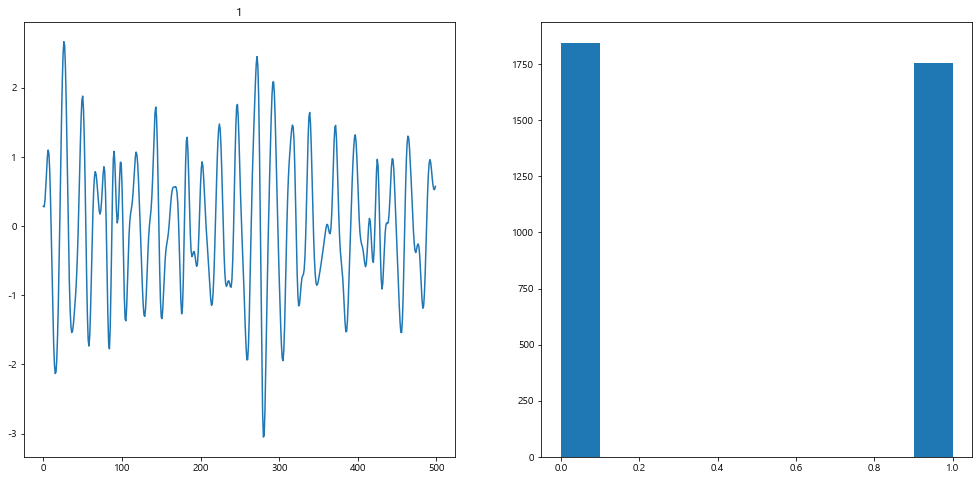

In [52]:
print(x_train.shape, y_train.shape)
idx = 10
plt.figure(figsize=(17,8))
plt.subplot(121)
plt.title(y_train[idx])
plt.plot(x_train[idx])
plt.subplot(122)
plt.hist(y_train)
plt.show()


### **| 모델 구현**

In [64]:
# Set params
input_shape = (500, 1)  # (T/s, d_model)
n_classes = 2
h = 4
N = 4
d_k = 128
d_ff = 4

# Set Input
inputs = tf.keras.layers.Input(shape=input_shape)

y = inputs
# Encoder Block
for i in range(N):
    encoder = encoder_block(input_shape, h, d_k, d_ff, dropout=0.25, name=None)
    y = encoder(y)
# Classifier
y = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(y)
y = tf.keras.layers.Dense(128, activation="leaky_relu",)(y)
y = tf.keras.layers.Dropout(0.5)(y)
y = tf.keras.layers.Dense(n_classes, activation="softmax")(y)
# Final model
model = tf.keras.models.Model(inputs, y, name="TransformerEncoder")
model.summary()

Model: "TransformerEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 500, 1)]          0         
                                                                 
 model_36 (Functional)       (None, 500, 1)            3602      
                                                                 
 model_37 (Functional)       (None, 500, 1)            3602      
                                                                 
 model_38 (Functional)       (None, 500, 1)            3602      
                                                                 
 model_39 (Functional)       (None, 500, 1)            3602      
                                                                 
 global_average_pooling1d_5   (None, 500)              0         
 (GlobalAveragePooling1D)                                        
                                                

In [66]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001),metrics="acc")
es = tf.keras.callbacks.EarlyStopping(monitor="val_acc",patience=8, restore_best_weights=True)
model.fit(x_train, y_train, validation_data=[x_test, y_test], batch_size=32, epochs=50, callbacks=[es])

Epoch 1/50
113/113 [==============================] - 17s 127ms/step - loss: 1.1015 - acc: 0.4957 - val_loss: 0.7201 - val_acc: 0.5530
Epoch 2/50
113/113 [==============================] - 14s 123ms/step - loss: 0.9093 - acc: 0.5585 - val_loss: 0.6668 - val_acc: 0.6091
Epoch 3/50
113/113 [==============================] - 14s 124ms/step - loss: 0.8573 - acc: 0.5779 - val_loss: 0.6377 - val_acc: 0.6455
Epoch 4/50
113/113 [==============================] - 14s 123ms/step - loss: 0.7897 - acc: 0.6015 - val_loss: 0.6114 - val_acc: 0.6697
Epoch 5/50
113/113 [==============================] - 14s 124ms/step - loss: 0.7578 - acc: 0.6226 - val_loss: 0.5972 - val_acc: 0.6833
Epoch 6/50
113/113 [==============================] - 14s 124ms/step - loss: 0.7148 - acc: 0.6384 - val_loss: 0.5813 - val_acc: 0.6939
Epoch 7/50
113/113 [==============================] - 14s 124ms/step - loss: 0.7022 - acc: 0.6490 - val_loss: 0.5711 - val_acc: 0.7076
Epoch 8/50
113/113 [==============================] - 1

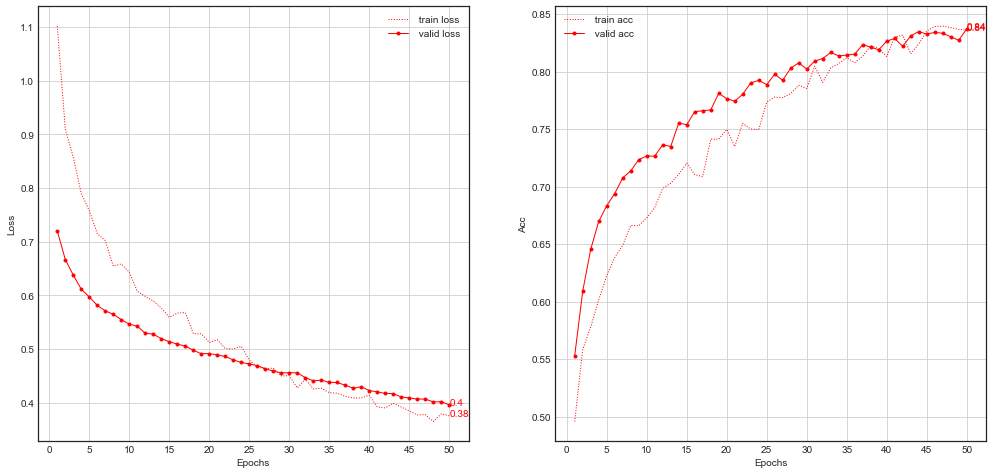

In [71]:
from Myfunc import show_lcurve
history = model.history
show_lcurve([history], [""], size=(17,8), x_itv=5)

## 실습2. IMDB 텍스트 분류
---

### **| IMDB 데이터셋**


In [ ]:
vocab_size = 20000  
maxlen = 200  

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
print(x_train.shape, x_val.shape)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


### **| 모델 구현**

In [ ]:
# Set params


# Set Input

# Encoder Block


# Classifier

# Final model


### **| 학습**

## 실습3. Vision Transformer
---

In [ ]:
def display_img_patches(img, patches):

  # origin image


  # patches

  # real patches


### **| 이미지 증강**

### **| Patch 생성**

### **| Patch Encoder**


### **| 모델 구현**

In [ ]:
# Set params


# Set Input

# Encoder Block


# Classifier

# Final model
